In [1]:
from ANEMO import ANEMO
from ANEMO.edfreader import read_edf
import pickle
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import easydict

In [2]:
exp = {'px_per_deg': 27,
      'N_trials': 400,
      'N_blocks': 1,
      'list_events': ['StimulusOn\n', 'StimulusOff\n',
                      'TargetOn\n', 'TargetOff\n']}

In [3]:
def moulti_fit(sujet, trial, nb_fit=25, perturbation=200):
    
    
    if sujet < 13 : datafile = 'data/new_data/s%sBLa50.asc'%(sujet)
    else :          datafile = 'data/new_data/s%sBL50.asc'%(sujet)
    #data = read_edf(datafile, 'Trialinfo')
    data_full = read_edf(datafile, 'Trialinfo')
    
    exp['dir_target'] = [[]]
    for t in range(exp['N_trials']) :
        if data_full[t]['events']['msg'][0][1][-2] in ['0','2'] : exp['dir_target'][0].append(1)
        else :                                                    exp['dir_target'][0].append(0)
            
    
    A = ANEMO(exp) 
    Fit = ANEMO.Fit(exp)
    Plot = ANEMO.Plot(exp)

    #= 1 ===============================================================================================
    

    Plot.plot_fit(data_full, trials=trial, fig_width=30)

    arg = A.arg(data_full[trial], trial=trial, block=0)
    velocity = A.velocity_NAN(**arg)
    old_latency, old_steady_state, old_anti = A.classical_method.Full(velocity, arg.TargetOn-arg.t_0)
    rere = Fit.Fit_trial(velocity, value_latency=old_latency, value_steady_state=old_steady_state, value_anti=old_anti, **arg)
    
    result_full_data = rere.values
    for k in ['latency', 'start_anti'] :
        result_full_data[k] = result_full_data[k] - (arg.TargetOn-arg.t_0)
    #print('result_full_data =', result_full_data)

    #= 2 ===============================================================================================
    #color = 'g'
    result_red_data = []
    
    step = 2
    #i=0
    
    for color, i in zip(['g', 'b'], [0,1]) :
        
        
        data_red = read_edf(datafile, 'Trialinfo')
        for var in data_red[trial].keys() :
            if var != 'events' :
                data_red[trial][var] = np.array([data_red[trial][var][x] for x in range(i, len(data_red[trial][var]), step)])        
        arg_red = A.arg(data_red[trial], trial=trial, block=0)

        #-------------------------------------------------------------------------------
        max_latency = len(arg.trackertime[:-int(280/step)])


        a = easydict.EasyDict()
        for v in ['StimulusOn', 'StimulusOf', 'TargetOn', 'TargetOff','t_0']:
            a[v] = int(arg_red[v]/step)
        
        #-------------------------------------------------------------------------------
        veve = [velocity[t] for t in np.arange(i, len(velocity), step)]
        value_latency = A.classical_method.latency(veve)
        value_anti = np.nanmean(veve[(a.TargetOn-a.t_0)-int(50/step):(a.TargetOn-a.t_0)+int(50/step)])
        value_steady_state = abs(np.nanmean(veve[(a.TargetOn-a.t_0)+int(400/step):(a.TargetOn-a.t_0)+int(600/step)]))

        if value_latency >= max_latency-(50/step) : value_latency = max_latency-(150/step)
        if value_latency > (250/step) :             value_latency = a.TargetOn-a.t_0+(100/step)
        if np.isnan(value_latency) :                value_latency = a.TargetOn-a.t_0+(100/step)


        #-------------------------------------------------------------------------------
        np.random.seed(10)
        list_latency = value_latency + perturbation*np.random.rand(nb_fit)*np.random.choice([-1,1], nb_fit)
        print(list_latency)


        #-------------------------------------------------------------------------------
        for lat in list_latency :

            param_fit=[{'name':'steady_state', 'value':value_steady_state, 'min':5., 'max':40., 'vary':True},
                       {'name':'dir_target',   'value':arg_red.dir_target, 'min':None, 'max':None, 'vary':False},
                       {'name':'a_anti',       'value':lat*step, 'min':-40.*step, 'max':40.*step, 'vary':True},
                       {'name':'latency',      'value':value_latency,
                          'min':a.TargetOn-a.t_0+(75/step), 'max':max_latency, 'vary':True},
                       {'name':'start_anti',   'value':a.TargetOn-a.t_0-(100/step),
                          'min':a.StimulusOf-a.t_0-(200/step), 'max':a.TargetOn-a.t_0+(75/step), 'vary':'vary'},
                       {'name':'tau',  'value':15., 'min':13., 'max':80., 'vary':'vary'}]

            inde_vars={'x':np.arange(len(arg_red.trackertime[:-int(280/step)]))}
            #print(len(inde_vars['x']), len(veve))
            #===================================================================
            rere = Fit.Fit_trial(veve, param_fit=param_fit, inde_vars=inde_vars, time_sup=int(280/step))
            result_red = rere.values
            result_red['a_anti'] = result_red['a_anti']/step
            for k in ['latency', 'start_anti'] :
                result_red[k] = result_red[k]*step

            fit = A.Equation.fct_velocity(arg.trackertime[:-280]-arg.t_0, **result_red)
            plt.plot(arg.trackertime[:-280]-arg.TargetOn, fit, c=color)

            for k in ['latency', 'start_anti'] : result_red[k] = result_red[k] - (arg.TargetOn-arg.t_0)
            result_red_data.append(result_red)

    return(result_full_data, result_red_data)

In [4]:
def histoto(result_full_data_, result_red_data_, name, color, bins=50):
    
    
    x_range = {'steady_state': [ 5,  40], 'a_anti':     [ -40, 40],
               'latency':      [75, 500], 'start_anti': [-500, 75],
               'tau':          [13,  80]}
    
    list_, list_var = result_full_data_[0].keys(), []
    for v in list_: 
        if v not in ['dir_target', 'do_whitening'] : list_var.append(v)

    nb_var = len(list_var)
    fig, ax = plt.subplots(nb_var, len(result_full_data_), figsize=(5*len(result_full_data_),5*nb_var/1.681))
    
    for r in range(len(result_full_data_)) :
        
        result_full_data = result_full_data_[r]
        result_red_data = result_red_data_[r]
        
        
        for nb_var, v in enumerate(list_var) :
        
            result_v = []
            for n in range(len(result_red_data)) :
                result_v.append(result_red_data[n][v])

            hi = ax[nb_var][r].hist(result_v, range=x_range[v], color=color[r], alpha=.7, density=True, bins=bins)#, histtype='step', align='mid')
            ax[nb_var][r].bar(result_full_data[v], np.max(hi[0]), width=(x_range[v][0]-x_range[v][1])/(bins*2), color='k')    
            ax[nb_var][r].set_title(v+name[r], fontsize=20)
            
            ax[nb_var][r].text(x_range[v][1]-(x_range[v][1]-x_range[v][0])/50,
                               np.max(hi[0])-np.max(hi[0])/50,
                               'true: %.1f\nmean: %.1f +/- %.1f'%(result_full_data[v], np.mean(result_v), np.std(result_v)),
                               ha='right', va='top', fontsize=20)
    plt.tight_layout()

# Good

[408.73587135 567.15038987 689.72964699 712.76077651 463.29859754
 607.95932911 523.38742705 715.10614244 596.82216731 545.33203717
 700.07196367 372.32133076 562.21034673 665.43845268 400.47580767
 440.49478663 418.64893651 621.37521363 746.5548245  420.08484332
 454.4911264  534.56599048 637.66815201 428.17327699 651.36663488]


/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/lo

[407.73587135 566.15038987 688.72964699 711.76077651 462.29859754
 606.95932911 522.38742705 714.10614244 595.82216731 544.33203717
 699.07196367 371.32133076 561.21034673 664.43845268 399.47580767
 439.49478663 417.64893651 620.37521363 745.5548245  419.08484332
 453.4911264  533.56599048 636.66815201 427.17327699 650.36663488]


/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/lo

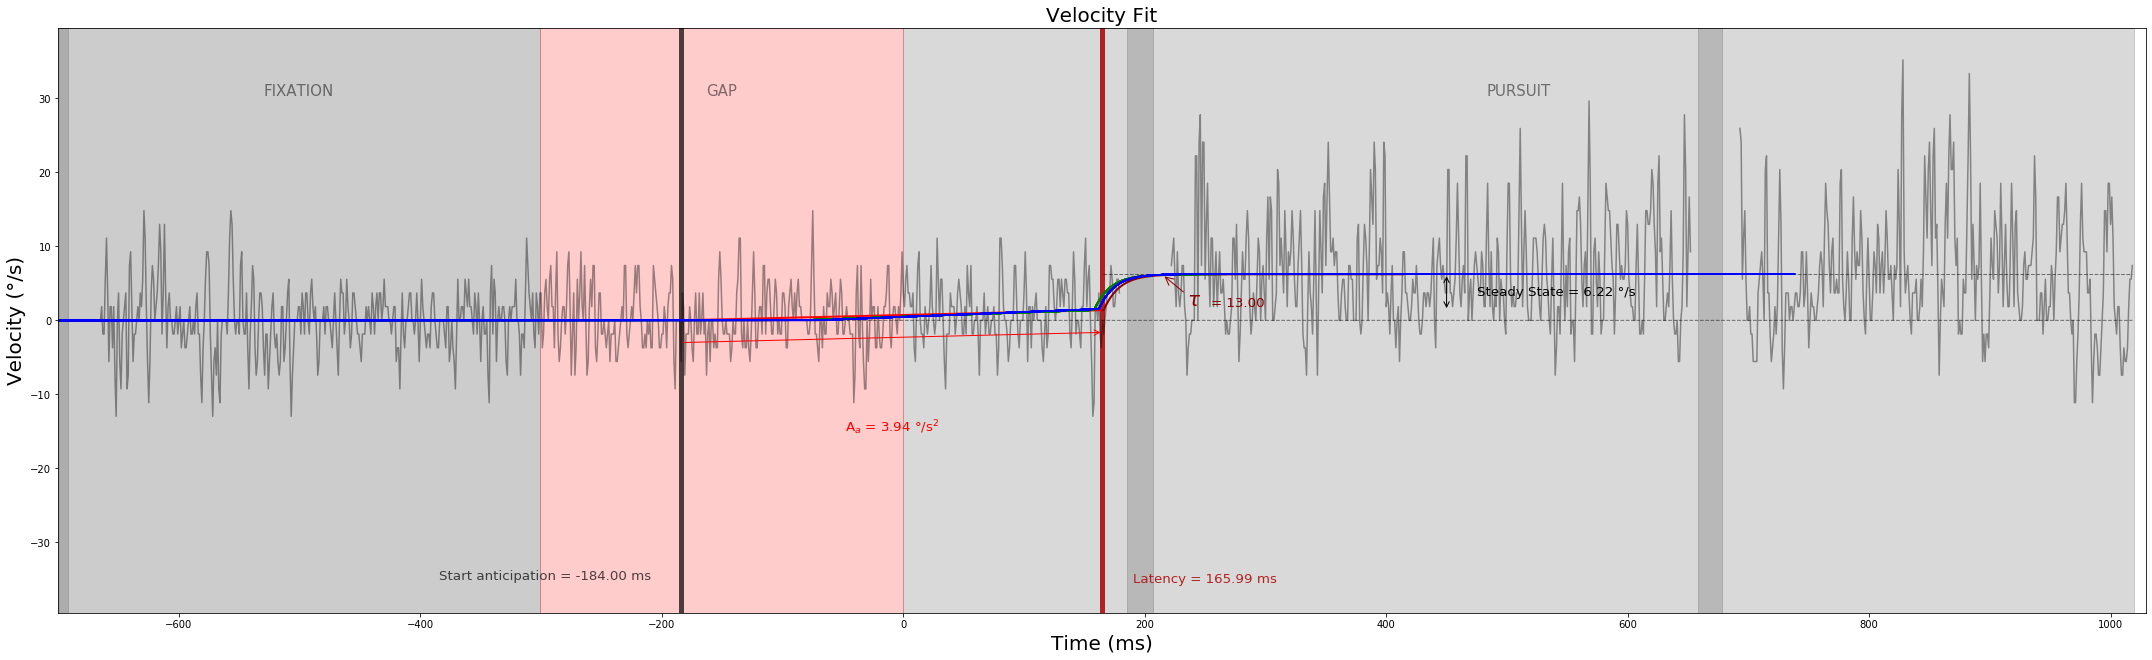

In [5]:
s, t = 1, 11
result_full_data_s1, result_red_data_s1 = moulti_fit(s, t)

[413.73587135 572.15038987 694.72964699 717.76077651 468.29859754
 612.95932911 528.38742705 720.10614244 601.82216731 550.33203717
 705.07196367 377.32133076 567.21034673 670.43845268 405.47580767
 445.49478663 423.64893651 626.37521363 751.5548245  425.08484332
 459.4911264  539.56599048 642.66815201 433.17327699 656.36663488]
[412.73587135 571.15038987 693.72964699 716.76077651 467.29859754
 611.95932911 527.38742705 719.10614244 600.82216731 549.33203717
 704.07196367 376.32133076 566.21034673 669.43845268 404.47580767
 444.49478663 422.64893651 625.37521363 750.5548245  424.08484332
 458.4911264  538.56599048 641.66815201 432.17327699 655.36663488]


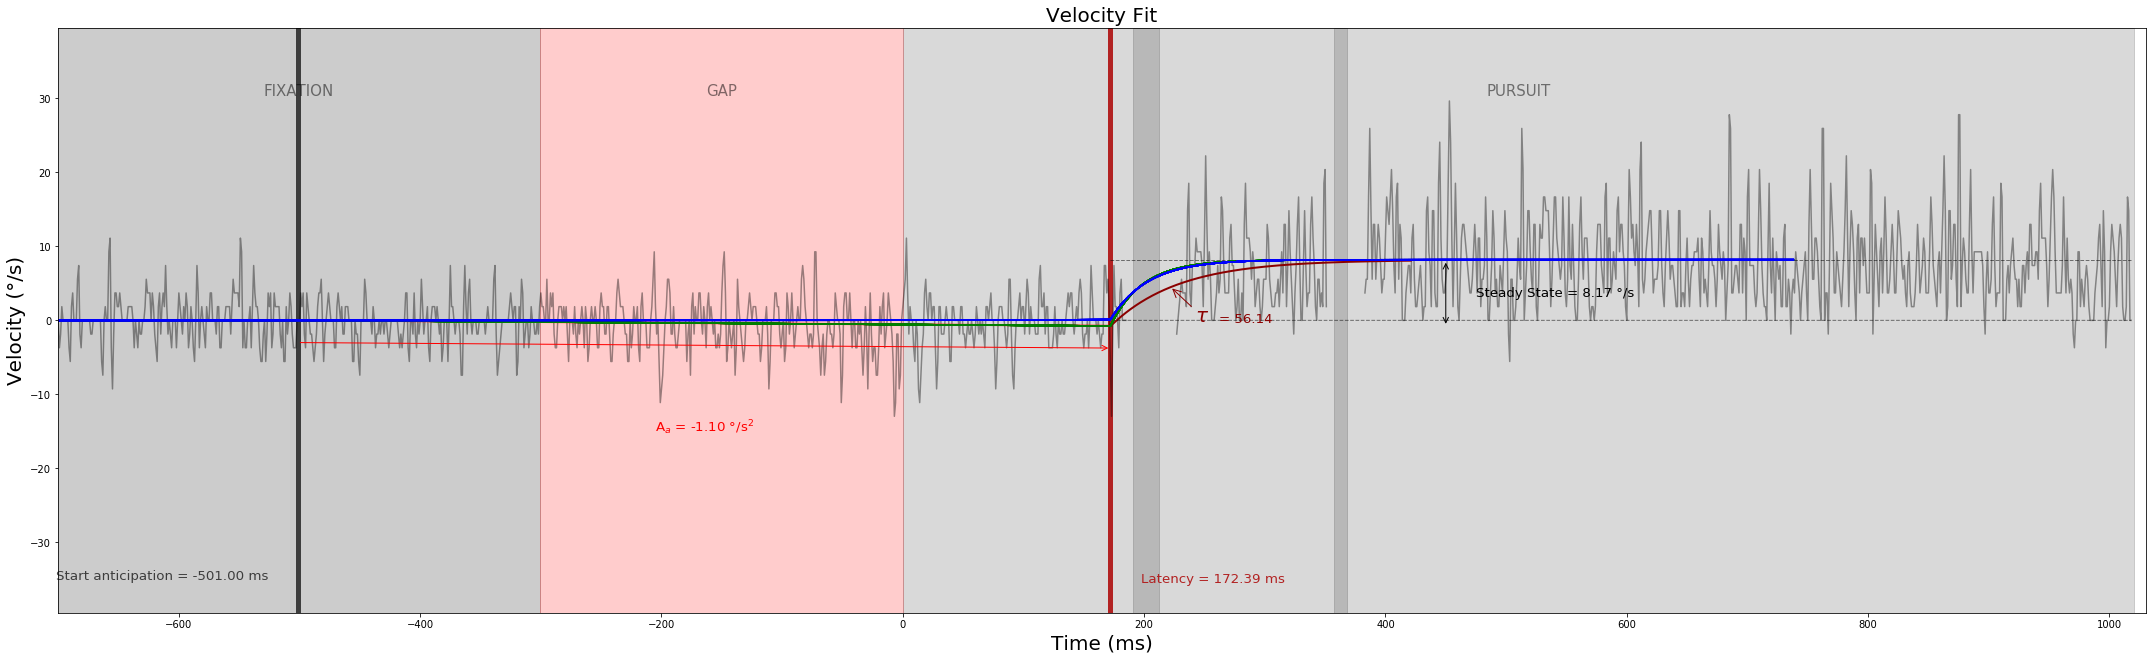

In [6]:
s, t = 2, 11
result_full_data_s2, result_red_data_s2 = moulti_fit(s, t)

[404.73587135 563.15038987 685.72964699 708.76077651 459.29859754
 603.95932911 519.38742705 711.10614244 592.82216731 541.33203717
 696.07196367 368.32133076 558.21034673 661.43845268 396.47580767
 436.49478663 414.64893651 617.37521363 742.5548245  416.08484332
 450.4911264  530.56599048 633.66815201 424.17327699 647.36663488]


/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/lo

[403.73587135 562.15038987 684.72964699 707.76077651 458.29859754
 602.95932911 518.38742705 710.10614244 591.82216731 540.33203717
 695.07196367 367.32133076 557.21034673 660.43845268 395.47580767
 435.49478663 413.64893651 616.37521363 741.5548245  415.08484332
 449.4911264  529.56599048 632.66815201 423.17327699 646.36663488]


/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/lo

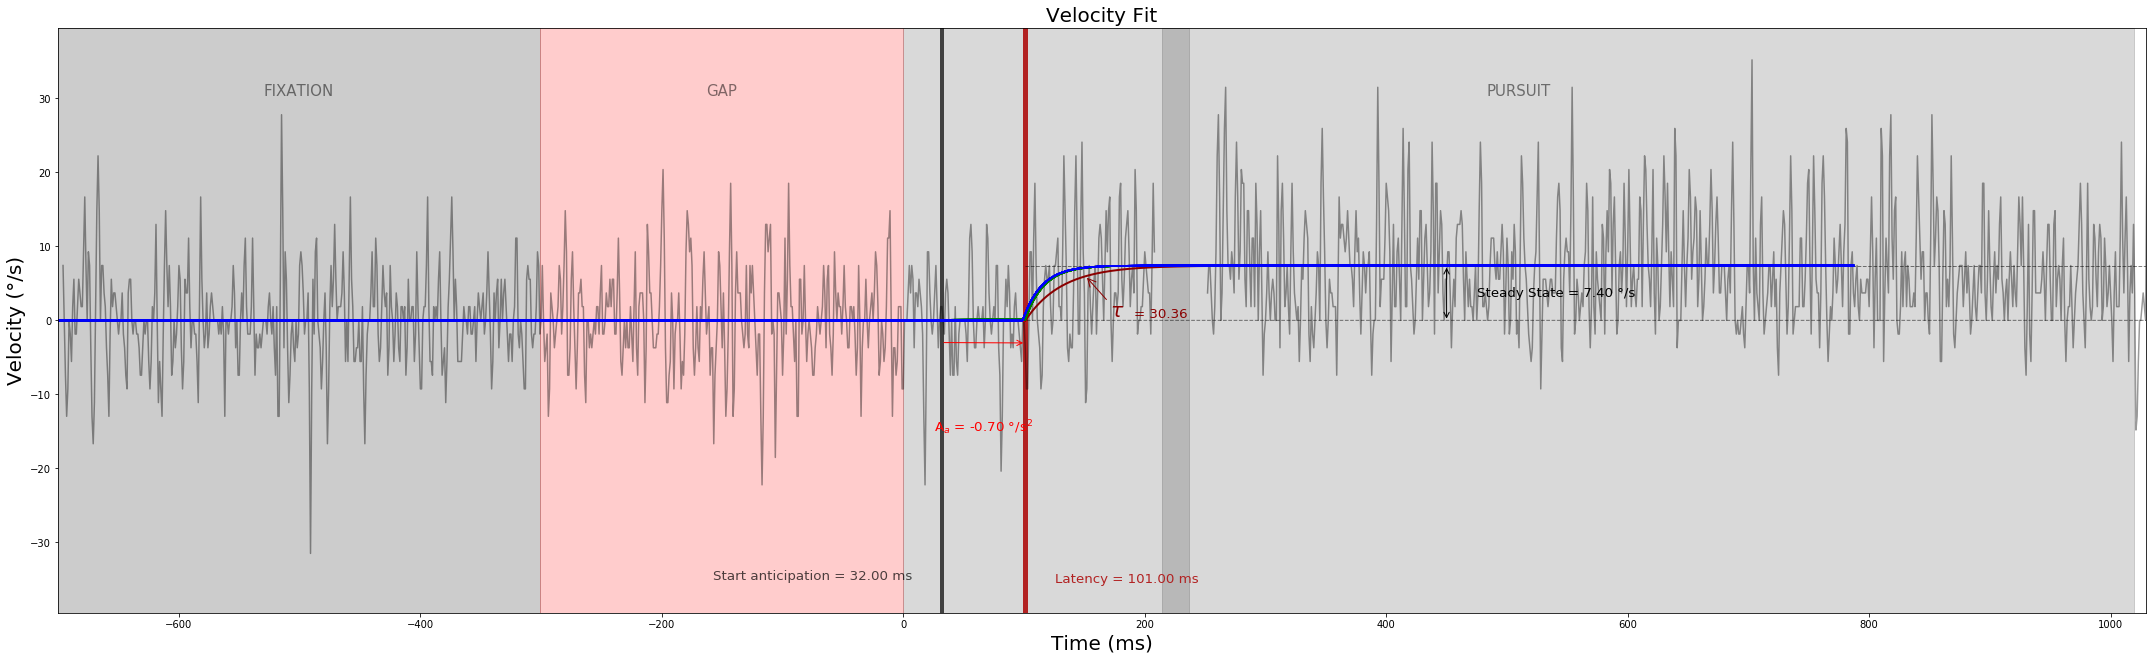

In [7]:
s, t = 3, 11
result_full_data_s3, result_red_data_s3 = moulti_fit(s, t)

[404.73587135 563.15038987 685.72964699 708.76077651 459.29859754
 603.95932911 519.38742705 711.10614244 592.82216731 541.33203717
 696.07196367 368.32133076 558.21034673 661.43845268 396.47580767
 436.49478663 414.64893651 617.37521363 742.5548245  416.08484332
 450.4911264  530.56599048 633.66815201 424.17327699 647.36663488]


/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/lo

[403.73587135 562.15038987 684.72964699 707.76077651 458.29859754
 602.95932911 518.38742705 710.10614244 591.82216731 540.33203717
 695.07196367 367.32133076 557.21034673 660.43845268 395.47580767
 435.49478663 413.64893651 616.37521363 741.5548245  415.08484332
 449.4911264  529.56599048 632.66815201 423.17327699 646.36663488]


/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/lo

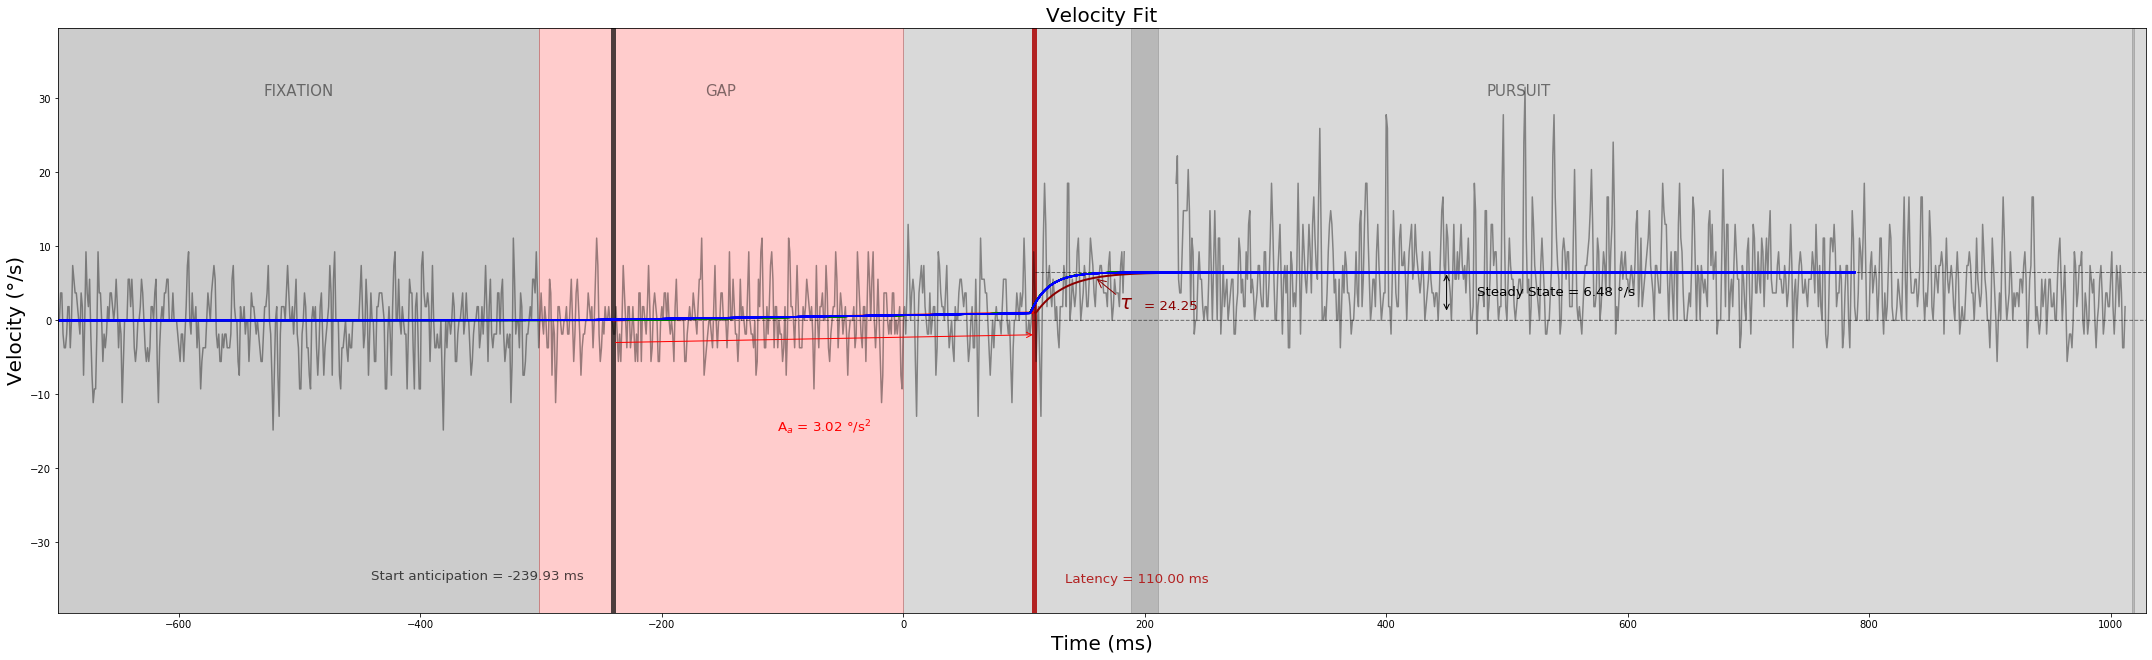

In [8]:
s, t = 4, 11
result_full_data_s4, result_red_data_s4 = moulti_fit(s, t)

# Bad

[369.73587135 528.15038987 650.72964699 673.76077651 424.29859754
 568.95932911 484.38742705 676.10614244 557.82216731 506.33203717
 661.07196367 333.32133076 523.21034673 626.43845268 361.47580767
 401.49478663 379.64893651 582.37521363 707.5548245  381.08484332
 415.4911264  495.56599048 598.66815201 389.17327699 612.36663488]
[368.73587135 527.15038987 649.72964699 672.76077651 423.29859754
 567.95932911 483.38742705 675.10614244 556.82216731 505.33203717
 660.07196367 332.32133076 522.21034673 625.43845268 360.47580767
 400.49478663 378.64893651 581.37521363 706.5548245  380.08484332
 414.4911264  494.56599048 597.66815201 388.17327699 611.36663488]


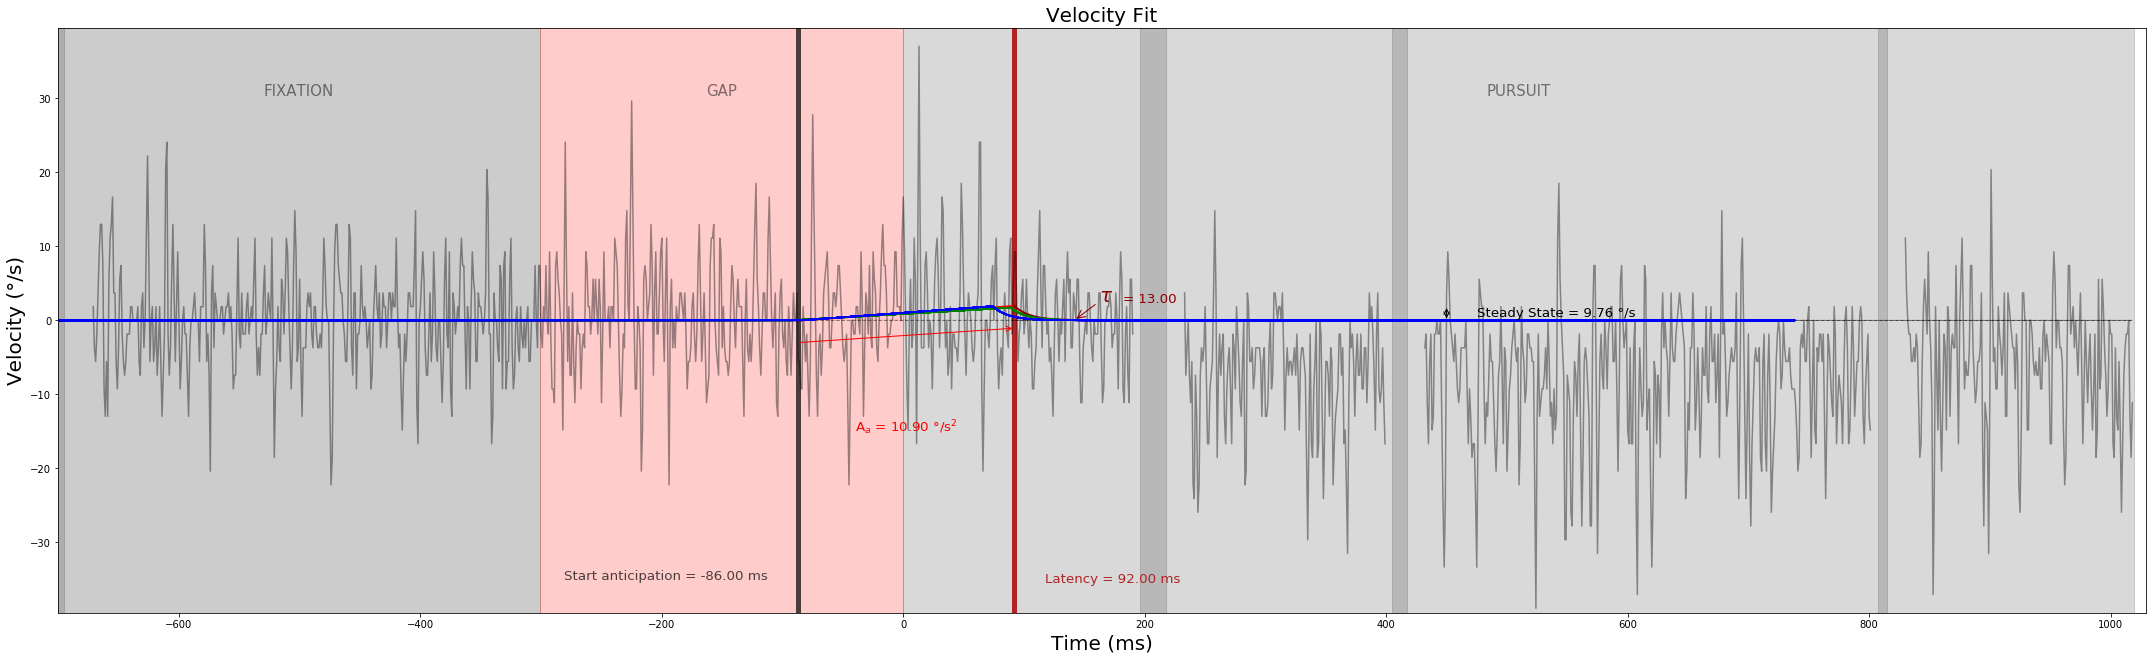

In [9]:
s, t = 1, 391
result_full_data_s1_391, result_red_data_s1_391 = moulti_fit(s, t)

[348.73587135 507.15038987 629.72964699 652.76077651 403.29859754
 547.95932911 463.38742705 655.10614244 536.82216731 485.33203717
 640.07196367 312.32133076 502.21034673 605.43845268 340.47580767
 380.49478663 358.64893651 561.37521363 686.5548245  360.08484332
 394.4911264  474.56599048 577.66815201 368.17327699 591.36663488]
[347.73587135 506.15038987 628.72964699 651.76077651 402.29859754
 546.95932911 462.38742705 654.10614244 535.82216731 484.33203717
 639.07196367 311.32133076 501.21034673 604.43845268 339.47580767
 379.49478663 357.64893651 560.37521363 685.5548245  359.08484332
 393.4911264  473.56599048 576.66815201 367.17327699 590.36663488]


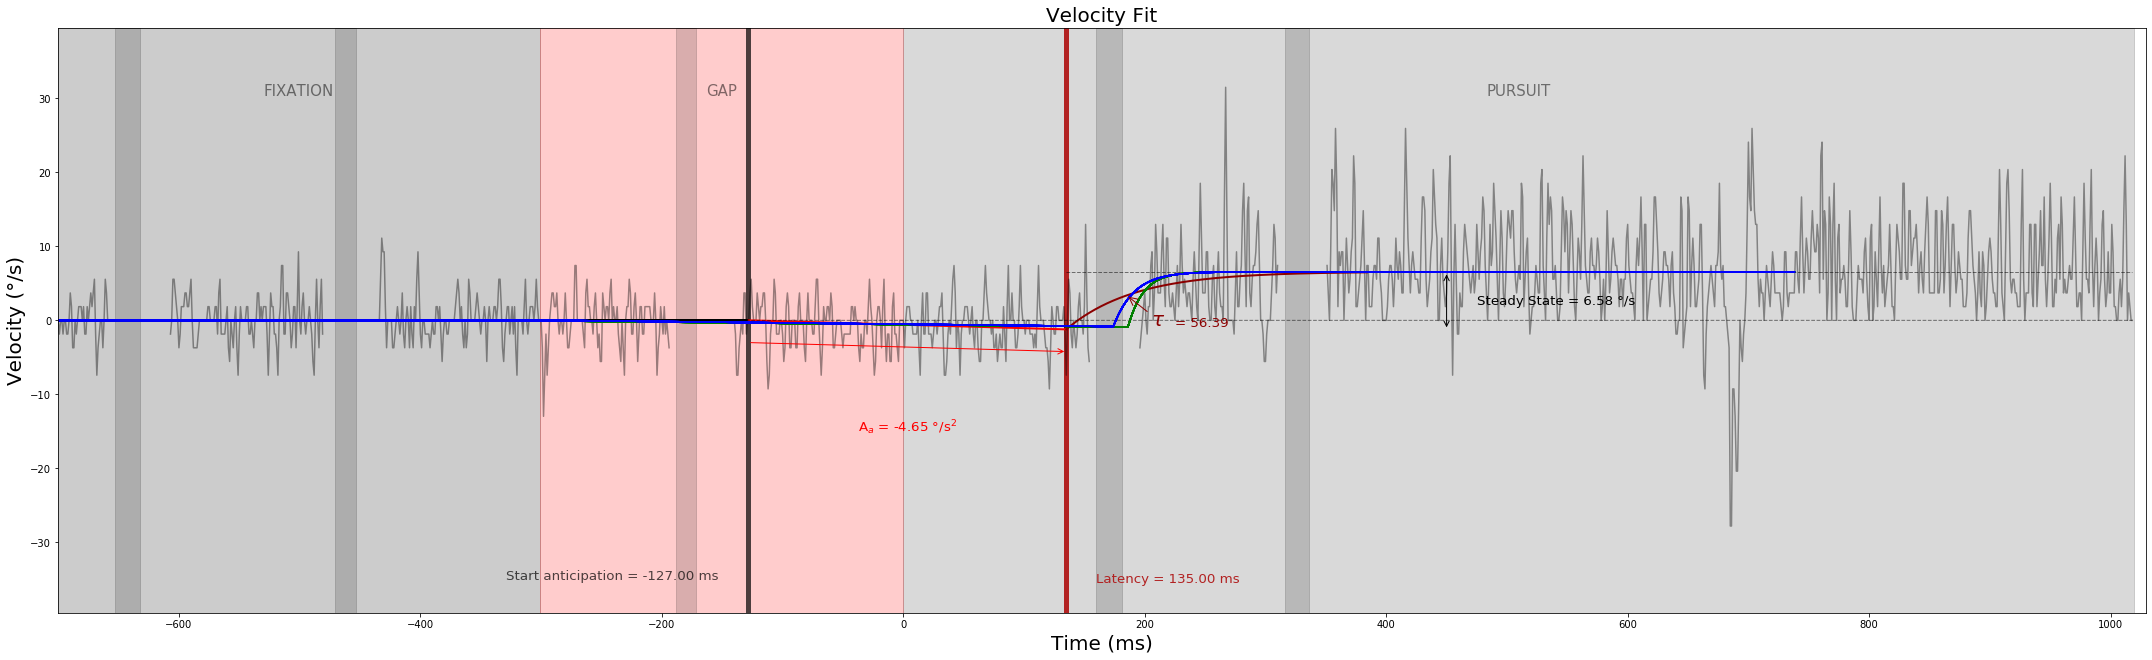

In [10]:
s, t = 2, 18
result_full_data_s2_18, result_red_data_s2_18 = moulti_fit(s, t)

[293.73587135 452.15038987 574.72964699 597.76077651 348.29859754
 492.95932911 408.38742705 600.10614244 481.82216731 430.33203717
 585.07196367 257.32133076 447.21034673 550.43845268 285.47580767
 325.49478663 303.64893651 506.37521363 631.5548245  305.08484332
 339.4911264  419.56599048 522.66815201 313.17327699 536.36663488]
[293.73587135 452.15038987 574.72964699 597.76077651 348.29859754
 492.95932911 408.38742705 600.10614244 481.82216731 430.33203717
 585.07196367 257.32133076 447.21034673 550.43845268 285.47580767
 325.49478663 303.64893651 506.37521363 631.5548245  305.08484332
 339.4911264  419.56599048 522.66815201 313.17327699 536.36663488]


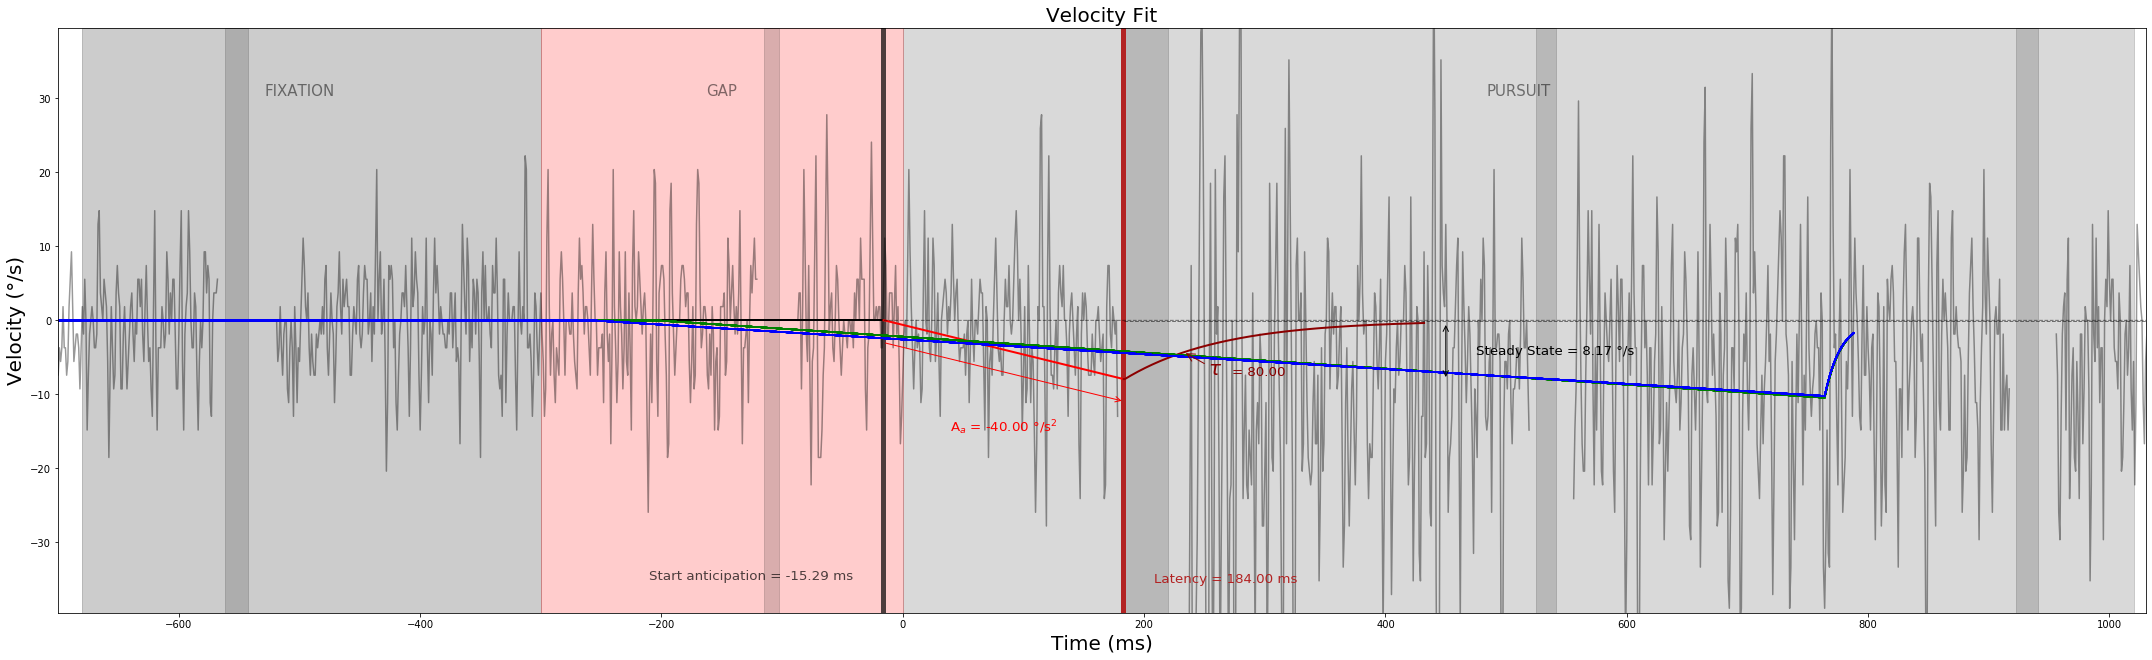

In [11]:
s, t = 3, 61
result_full_data_s3_61, result_red_data_s3_61 = moulti_fit(s, t)

[368.73587135 527.15038987 649.72964699 672.76077651 423.29859754
 567.95932911 483.38742705 675.10614244 556.82216731 505.33203717
 660.07196367 332.32133076 522.21034673 625.43845268 360.47580767
 400.49478663 378.64893651 581.37521363 706.5548245  380.08484332
 414.4911264  494.56599048 597.66815201 388.17327699 611.36663488]
[368.73587135 527.15038987 649.72964699 672.76077651 423.29859754
 567.95932911 483.38742705 675.10614244 556.82216731 505.33203717
 660.07196367 332.32133076 522.21034673 625.43845268 360.47580767
 400.49478663 378.64893651 581.37521363 706.5548245  380.08484332
 414.4911264  494.56599048 597.66815201 388.17327699 611.36663488]


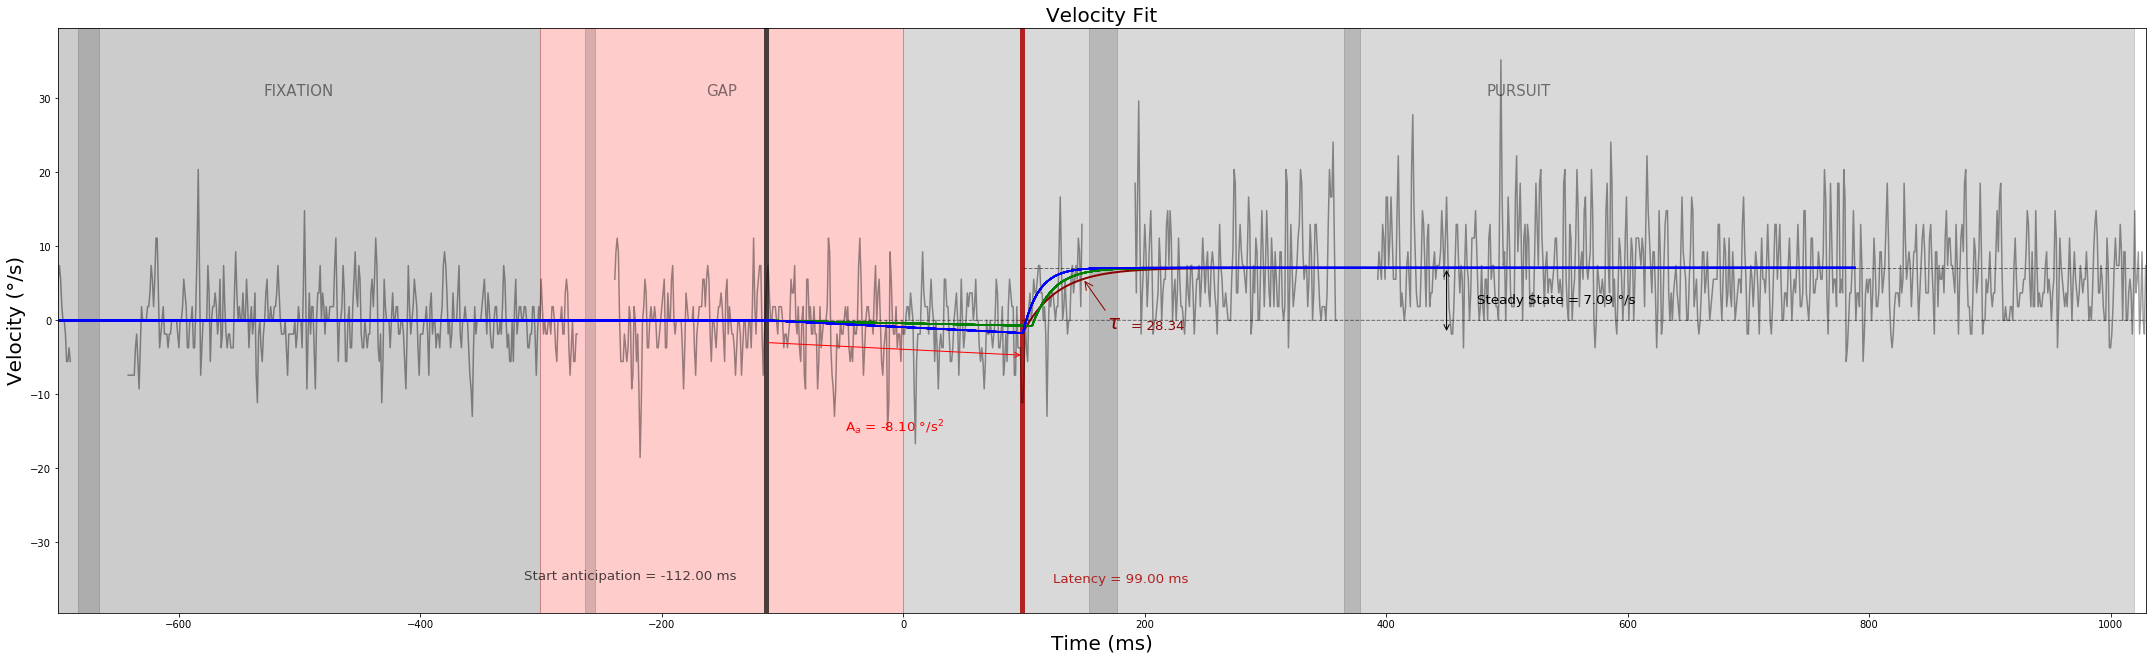

In [12]:
s, t = 4, 49
result_full_data_s4_49, result_red_data_s4_49 = moulti_fit(s, t)

# Hist

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:898: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


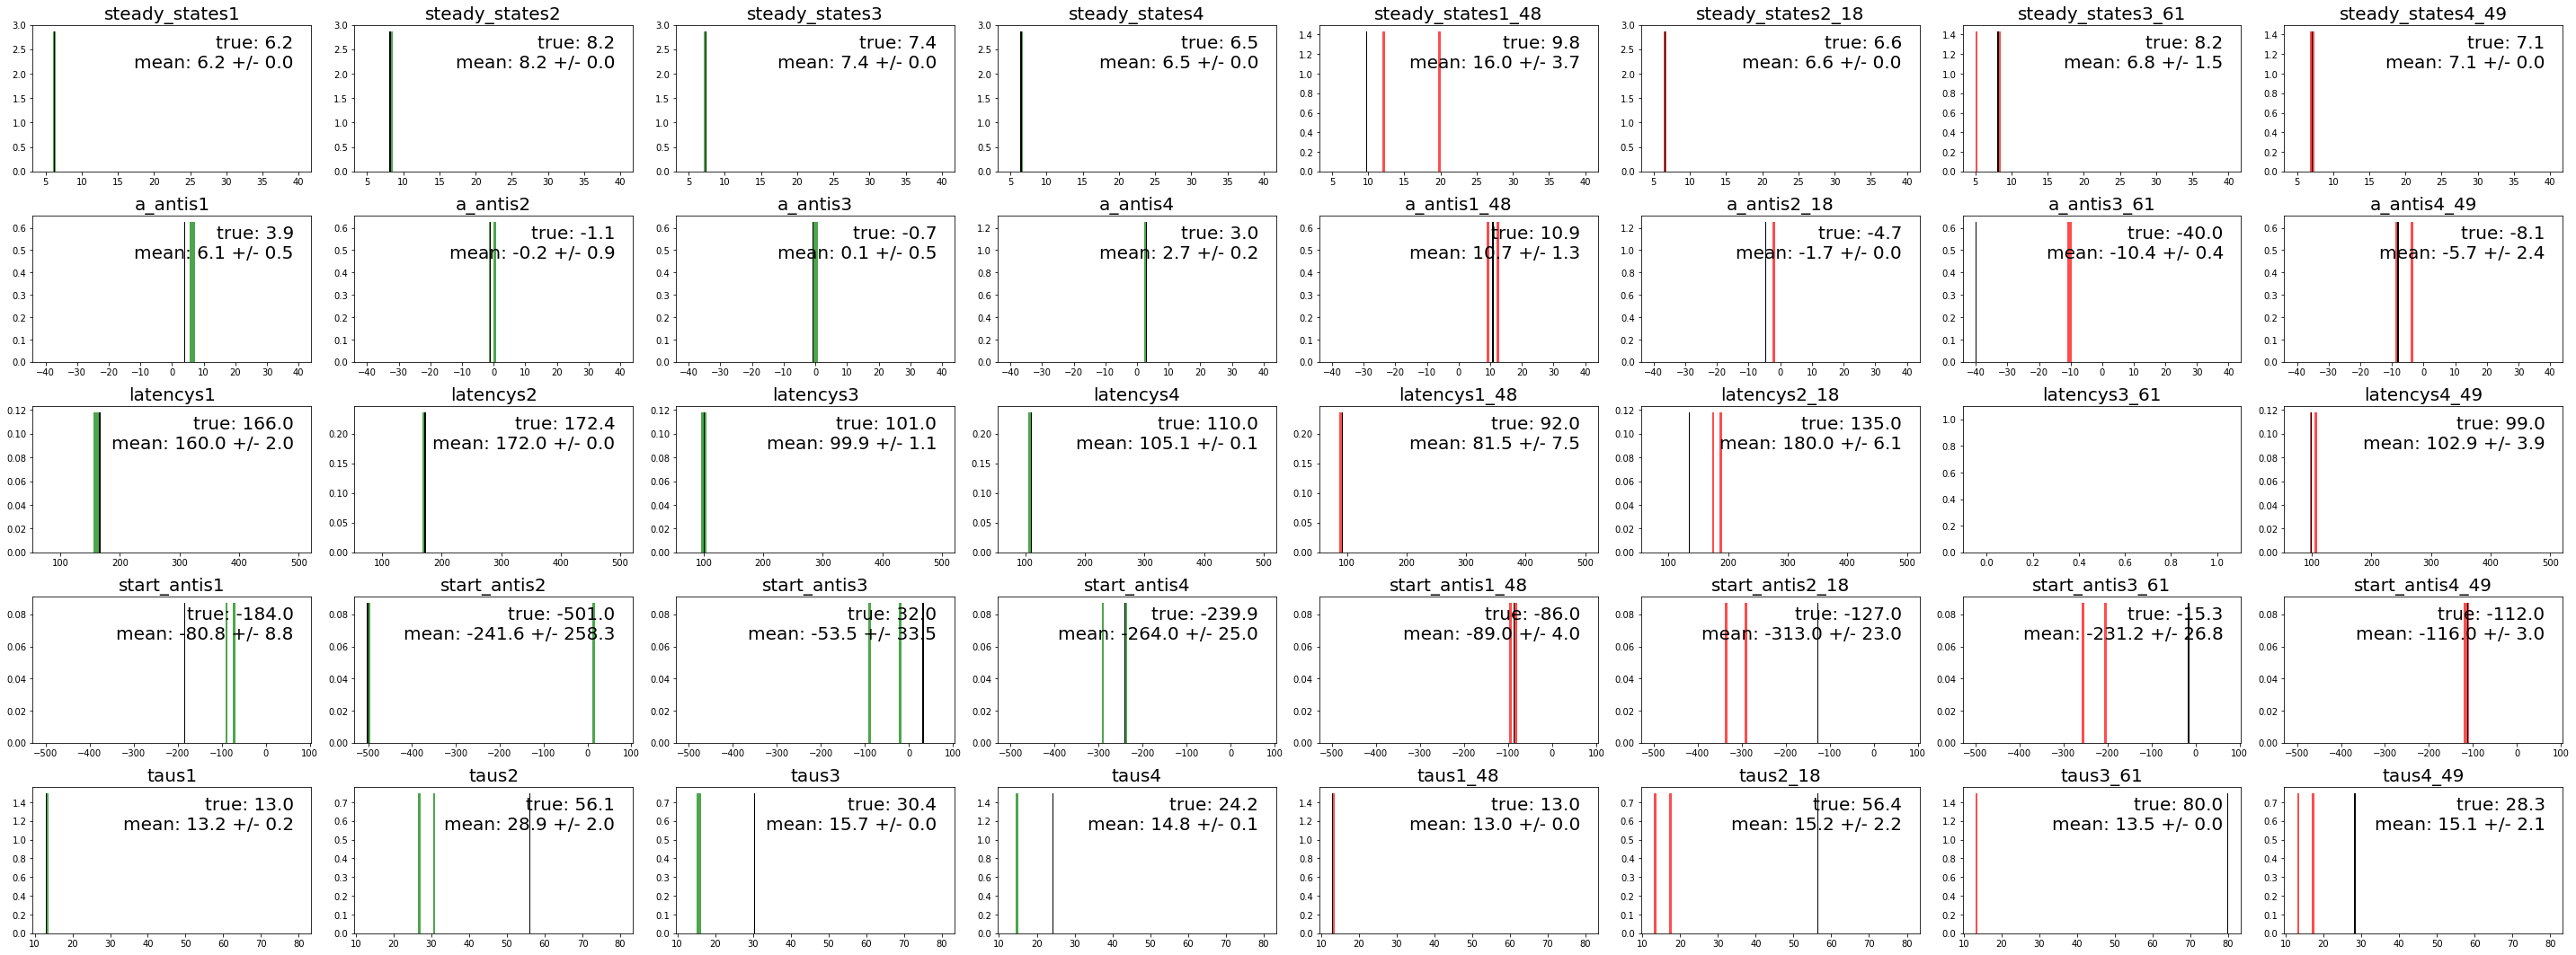

In [14]:
histoto([result_full_data_s1, result_full_data_s2, result_full_data_s3, result_full_data_s4,
         result_full_data_s1_391, result_full_data_s2_18, result_full_data_s3_61, result_full_data_s4_49],
        [result_red_data_s1, result_red_data_s2, result_red_data_s3, result_red_data_s4,
         result_red_data_s1_391, result_red_data_s2_18, result_red_data_s3_61, result_red_data_s4_49],
        ['s1', 's2', 's3', 's4', 's1_391', 's2_18', 's3_61', 's4_49'],
        [ 'g',  'g',  'g',  'g',    'r',      'r',     'r',     'r'], bins=100)